In [9]:
import numpy as np
from modules.polyfit import Polyfit
from modules.paramtune import Paramtune

#set to False for gpu
cpu = True

# dummy_data experiment
target_file = 'test_data/dummy_data/target_data.json'
mc_runs_file = 'test_data/dummy_data/inputdata.h5'
polyfit_file = 'test_data/dummy_data/fits.npz'
lasso_polyfit_file = 'test_data/dummy_data/lasso_fits.npz'
#fit both observables
select_obs = np.array(["/func0","/func1"])
#target all 40 bins
target_bins = None
param_names = ['a','b']
graph_range = [None,None]
chi2_runs = 3
sample_prop = 0.71
chi2_no_err_file = 'test_data/dummy_data/chi2results_no_err.json'
chi2_w_cov_file = 'test_data/dummy_data/chi2results_w_cov.json'
chi2_graph_range = [0.1,10]


Preform inner and outer loop optimization

In [10]:
fits = Polyfit(polyfit_file, input_h5=mc_runs_file, order=3, covariance = True, select_obs = select_obs, cpu = cpu)
tune_no_err = Paramtune(polyfit_file, target_file, covariance = False, target_bins = target_bins, cpu = cpu)

lasso_fits = Polyfit(lasso_polyfit_file, input_h5=mc_runs_file, order=3, covariance = True,
                      reg_mode = 'lasso_w', reg_param = 0.02, select_obs = select_obs, cpu = cpu)
tune_w_cov = Paramtune(lasso_polyfit_file, target_file, covariance = True, target_bins = target_bins, cpu = cpu)

# tune_w_cov_lst_sq = Paramtune(polyfit_file, target_file, covariance = True, target_bins = target_bins, cpu = cpu)


Fitting observables  ['/func0' '/func1']
42 40 40
42 40 40
Attempting to fit 37 of 40: /func1#16                                                   
Bin  36  identically zero or has too many zero error across all runs, skipping!
Attempting to fit 38 of 40: /func1#17                                                   
Bin  37  identically zero or has too many zero error across all runs, skipping!
Attempting to fit 39 of 40: /func1#18                                                   
Bin  38  identically zero or has too many zero error across all runs, skipping!
Attempting to fit 40 of 40: /func1#19                                                   
Bin  39  identically zero or has too many zero error across all runs, skipping!

 4  bins skipped for zeros.

Fits written to test_data/dummy_data/fits.npz
loading  test_data/dummy_data/fits.npz
Calculated inital guess:  [ 1.46338909 -0.98584734]
Tuned Parameters:  [ 1.52333873 -1.02245463] , Objective =  8.828539120265315 , chi2/ndf =  0.2596

Visualize objective function (centered at p_opt)

target deviation 37.3614, with confidence level 0.6827, edof 34.0000
target deviation 37.3614, with confidence level 0.6827, edof 34.0000
target deviation 37.3614, with confidence level 0.6827, edof 34.0000
target deviation 37.3614, with confidence level 0.6827, edof 34.0000


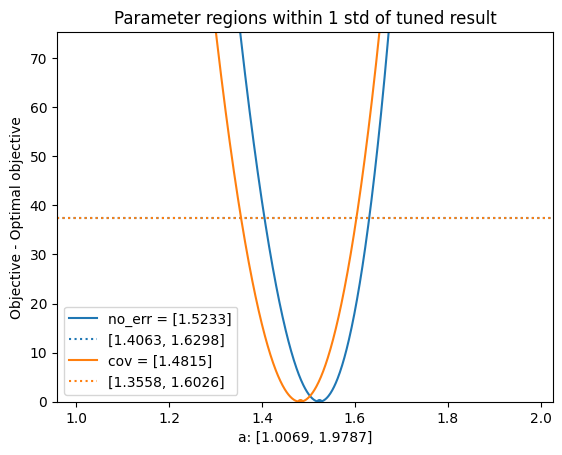

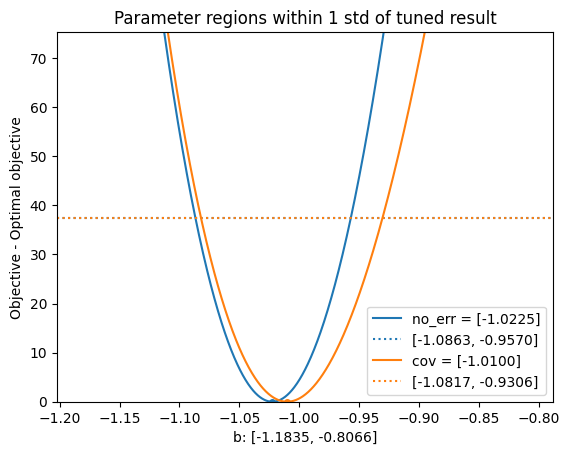

In [11]:
for i in range(len(param_names)):
    tune_no_err.graph_objective(param_names[i], graph_range = graph_range[i], log_scale = False)
    tune_w_cov.graph_objective(param_names[i], new_figure = False, graph_range = graph_range[i], log_scale = False)

# for i in range(len(param_names)):
#     tune_w_cov_lst_sq.graph_objective(param_names[i], graph_range = graph_range[i], log_scale = False)
#     tune_w_cov.graph_objective(param_names[i], new_figure = False, graph_range = graph_range[i], log_scale = False)

many chi2 experiment (will be moved to script)

Tuning with 3 samples of size 30 out of 42
Fitting observables  ['/func0' '/func1']
42 40 40
[34 30 16  7 22 39 33  2 18 31 19 23 17 29 11 24  5 25  8 12  9 14 32 13
 40 20 10  0 35 26]
30 40 40
Attempting to fit 37 of 40: /func1#16                                                   
Bin  36  identically zero or has too many zero error across all runs, skipping!
Attempting to fit 38 of 40: /func1#17                                                   
Bin  37  identically zero or has too many zero error across all runs, skipping!
Attempting to fit 39 of 40: /func1#18                                                   
Bin  38  identically zero or has too many zero error across all runs, skipping!
Attempting to fit 40 of 40: /func1#19                                                   
Bin  39  identically zero or has too many zero error across all runs, skipping!

 4  bins skipped for zeros.

Fits written to test_data/dummy_data/fits.npz
loading  test_data/dummy_data/fits.npz
Calculated ini

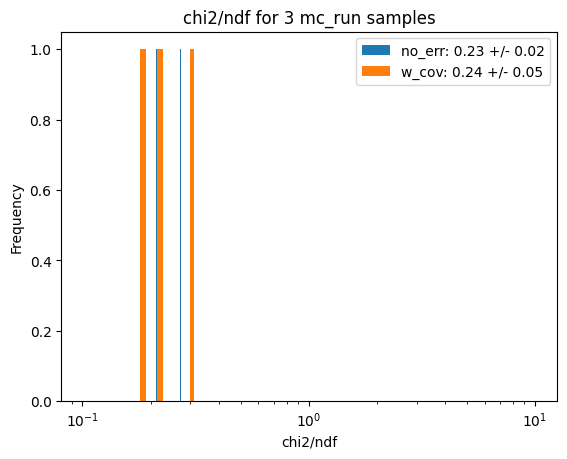

In [12]:
import json
import matplotlib.pyplot as plt
import jax.numpy as jnp
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure()
plt.title("chi2/ndf for " + str(chi2_runs) + " mc_run samples")
plt.ylabel("Frequency")
plt.xlabel("chi2/ndf")
plt.xscale('log')

num_runs = fits.X.shape[0]
sample_size = round(sample_prop * num_runs)
print("Tuning with", chi2_runs, "samples of size", sample_size, "out of", num_runs)
p_opt, chi2ndf = [],[]
for i in range(chi2_runs):
    s_fits = Polyfit(polyfit_file, sample=sample_size, input_h5=mc_runs_file, order=3, covariance = True, select_obs = select_obs, cpu = cpu)
    s_tune_no_err = Paramtune(polyfit_file, target_file, covariance = False, target_bins = target_bins, cpu = cpu)
    p_opt.append(s_tune_no_err.p_opt)
    chi2ndf.append(s_tune_no_err.objective(s_tune_no_err.p_opt.x, *s_tune_no_err.obj_args)/s_tune_no_err.ndf)

label = "no_err: {:.2f} +/- {:.2f}".format(jnp.mean(jnp.array(chi2ndf)), jnp.std(jnp.array(chi2ndf)))
plt.hist(chi2ndf, bins = 'doane', label = label, range = chi2_graph_range, facecolor = cycle_colors[0])
results = {}
results['chi2ndf'] = [c.tolist() for c in chi2ndf]
results['tuned_p'] = [list(p.x) for p in p_opt]
with open(chi2_no_err_file, "w") as f:
    json.dump(results, f, indent=4)


p_opt_cov, chi2ndf_cov = [],[]
for i in range(chi2_runs):
    s_lasso_fits = Polyfit(lasso_polyfit_file, sample=sample_size, input_h5=mc_runs_file, order=3, covariance = True,
                        reg_mode = 'lasso_w', reg_param = 0.02, select_obs = select_obs, cpu = cpu)
    s_tune_w_cov = Paramtune(lasso_polyfit_file, target_file, covariance = True, target_bins = target_bins, cpu = cpu)
    p_opt_cov.append(s_tune_w_cov.p_opt)
    chi2ndf_cov.append(s_tune_w_cov.objective(s_tune_w_cov.p_opt.x, *s_tune_w_cov.obj_args)/s_tune_w_cov.ndf)

label = "w_cov: {:.2f} +/- {:.2f}".format(jnp.mean(jnp.array(chi2ndf_cov)), jnp.std(jnp.array(chi2ndf_cov)))
plt.hist(chi2ndf_cov, bins = 'doane', label = label, range = chi2_graph_range, facecolor = cycle_colors[1])
plt.legend()
results = {}
results['chi2ndf'] = [c.tolist() for c in chi2ndf_cov]
results['tuned_p'] = [list(p.x) for p in p_opt_cov]
with open(chi2_w_cov_file, "w") as f:
    json.dump(results, f, indent=4)


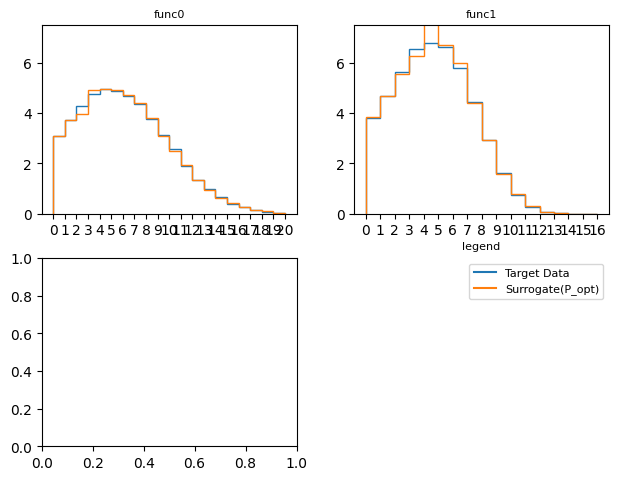

In [13]:
tune_no_err.graph_tune_all()

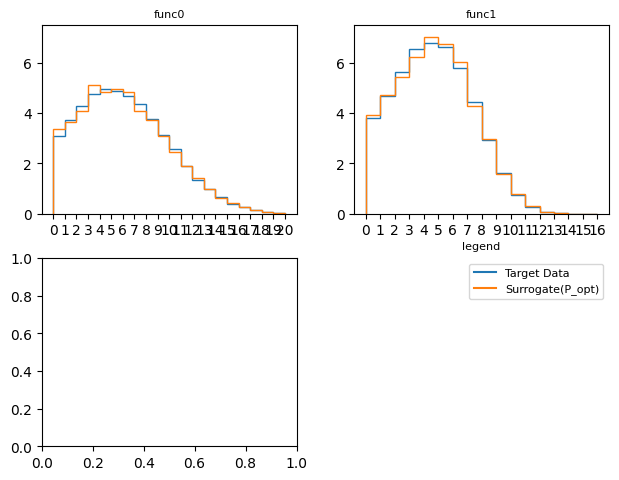

In [14]:
tune_w_cov.graph_tune_all()

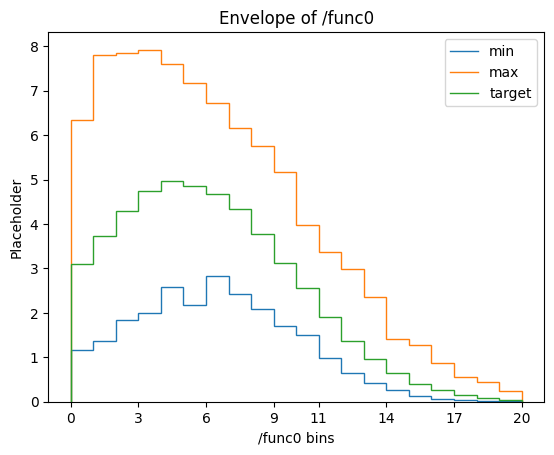

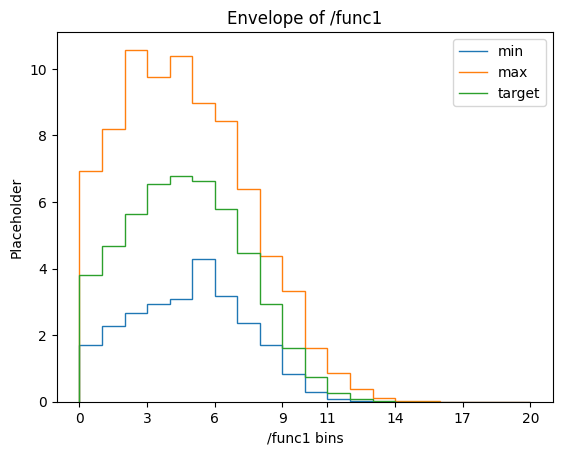

In [15]:
tune_no_err.graph_envelope_target()